# Analyze boop data

To extract frames from the Neuralink announcement video, [download the Neuralink Youtube video](https://www.youtube.com/watch?v=DVvmgjBL74w) in 720p and run ffmpeg to dump the frames to a folder:

`ffmpeg -i "Neuralink+Progress+Update,+Summer+2020.mp4" -vf select='between(n\,28500\,30500)' -vsync 0 frame%d.png`

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import scipy
from sklearn.linear_model import HuberRegressor

## Find the red bar to estimate timing of video

The video contains a big red vertical line indicating where in the raster the video is at. The red line sweeps the screen every 10 seconds. Track it. Use the red channel minus the green and blue channels to find these.

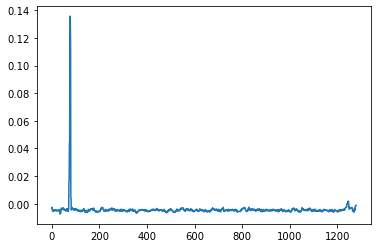

In [2]:
rgy = slice(307, 503)
red_bar_locations = []
for ii in range(1, 1675):
    the_im = mpimg.imread(f'frames/frame{ii}.png')
    the_line = (the_im[rgy, :, 0].astype(float) - .5 * the_im[rgy, :, 1].astype(float) - .5 * the_im[rgy, :, 1].astype(float)).mean(axis=0)
    red_bar_locations.append(np.argmax(the_line))
    
plt.plot(the_line)

Text(0.5, 1.0, 'Red bar location')

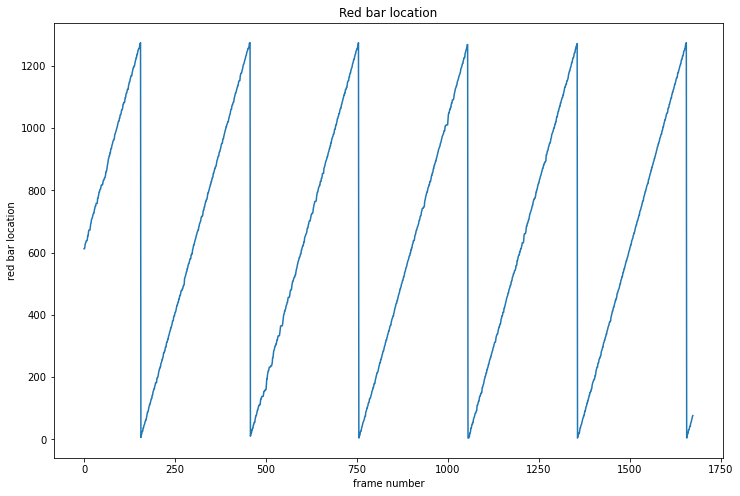

In [3]:
plt.figure(figsize=(12, 8))
plt.plot(red_bar_locations)
plt.xlabel('frame number')
plt.ylabel('red bar location')
plt.title('Red bar location')

(array([  0.,   0.,   2., 395.,   4., 163., 113., 285.,  17., 353.,  86.,
         85.,  25.,  98.,   1.,  14.,   9.,   4.,   1.,   7.,   1.,   3.,
          0.]),
 array([-3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,
         7.5,  8.5,  9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5,
        18.5, 19.5]),
 <BarContainer object of 23 artists>)

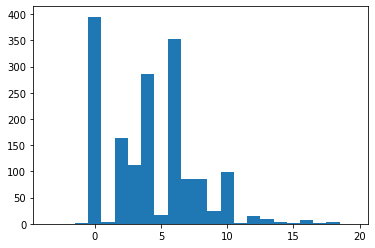

In [4]:
plt.hist(np.diff(red_bar_locations), np.arange(-3.5, 20))

You can see that the red bar is pretty jittery. It looks like a nice sawtooth wave with dents inside - the dents correspond to times when the display is not updated (presumably either the spikes, the real-time monitoring software or the video streaming software is buffering). The red bar moves right by 0, ~4, ~6 or 10 pixels per frame. Let's find a timebase that can fit this. The easiest is to use a linear regression to translate frames to pixels, but this is sensitive to outliers. We prefer a Huber regression, which is more robust.

In [5]:
frame_lens = np.diff(red_bar_locations)
mean_delta = np.mean(frame_lens[frame_lens > -10])
mean_delta

4.239352129574085

In [6]:
cuts = np.where((np.diff(red_bar_locations) < -10))[0]
cuts = np.concatenate([np.array([0]), cuts])

deltas = np.zeros((len(red_bar_locations), len(cuts)))

for i in range(len(cuts) - 1):
    subset = red_bar_locations[cuts[i]+1:cuts[i+1]+1]
    X = np.array([np.arange(len(subset)), np.ones(len(subset))]).T
    
    deltas[cuts[i]+1:cuts[i+1]+1, i] = 1
    deltas[cuts[i]+1:cuts[i+1]+1, -1] = X[:, 0]

In [7]:
y = np.array(red_bar_locations, dtype=np.float)
huber = HuberRegressor(epsilon=1.0, alpha=0.0, fit_intercept=False, max_iter=1000).fit(deltas[1:, :], y[1:])
huber.coef_

array([620.52110099,   6.12725252,   9.91803831,  -1.77367971,
        -1.82721584,   3.04538204,   4.24545508])

This tells us that on average, the red bar advances by `4.24545508` pixels to the right. Note that this subtly different than the simple estimate of the mean of the line deltas, which is 4.241. With this out of the way, we can get rasters and their timings.

In [8]:
S = []
ts = []

for idx in range(len(cuts) - 1):
    start_frame = cuts[idx] + 1
    end_frame = cuts[idx + 1] + 1

    red_bar_location_start = red_bar_locations[start_frame]
    red_bar_location_end = red_bar_locations[end_frame-1]
    the_im = mpimg.imread(f'frames/frame{end_frame}.png')
    
    print(red_bar_location_start, red_bar_location_end)
    
    im = the_im[rgy, red_bar_location_start:red_bar_location_end-2, 1]
    cloc = np.arange(red_bar_location_start,red_bar_location_end-2)
    t = (cloc - huber.coef_[idx] ) / huber.coef_[-1] + start_frame
    ts.append(t)
    S.append(im)
    
ts = np.concatenate(ts)
S = np.concatenate(S, axis=1).T
assert S.shape[0] == len(ts)

612 1274
6 1274
10 1274
4 1268
4 1271
4 1274


Text(0.5, 1.0, 'Sample raster plot')

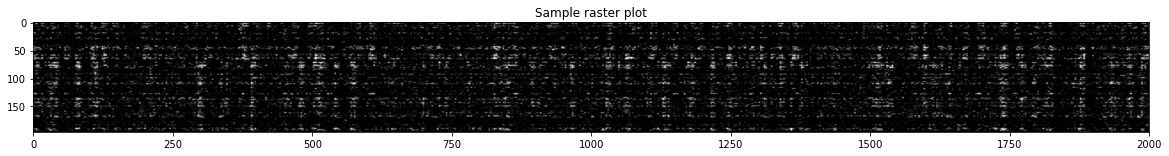

In [9]:
plt.figure(figsize=(20, 8))
plt.imshow(S.T, cmap='Greys_r')
plt.xlim((0, 2000))
plt.title('Sample raster plot')

Text(0, 0.5, 'average spike rate (A.U.)')

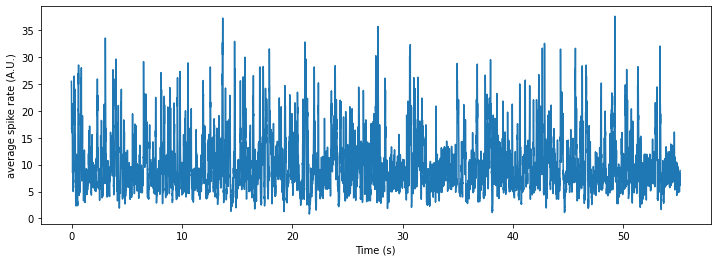

In [10]:
plt.figure(figsize=(12, 4))
plt.plot(ts / 30.0, S.sum(1))
plt.xlabel('Time (s)')
plt.ylabel('average spike rate (A.U.)')

Text(0, 0.5, 'singular value')

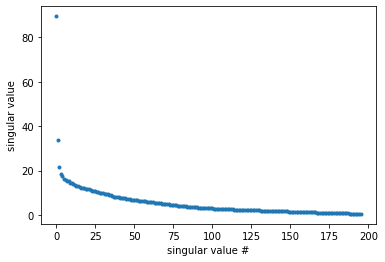

In [11]:
U, singular_vals, V = scipy.linalg.svd(S)
U.shape

plt.plot(singular_vals, '.')
plt.xlabel('singular value #')
plt.ylabel('singular value')

We see that the data is very low dimensional. Therefore, let's focus on doing reverse correlation on the average spike rate. I manually annotated the boop and unboop events.

In [13]:
df_boop = pd.read_csv('boops.csv')
df_boop.frame = df_boop.frame - 28500

def get_time_lagged_design(events, ts, frame_len, lag_deltas):
    d = []
    for i in lag_deltas:
        dd = 0
        for j in events:
            spike = 1.0 * (abs(j - ts - i * frame_len) <= frame_len)
            # dedup spike events
            spike[1:] = np.where((spike[1:] + spike[:-1]) == 2.0, 0.0, spike[1:])
            dd += spike
        d.append(dd)

    return np.stack(d).T

frame_len = np.median(np.diff(ts))
t_range = np.arange(-50, 50)

Text(0.5, 1.0, 'Unboop triggered average spike rate')

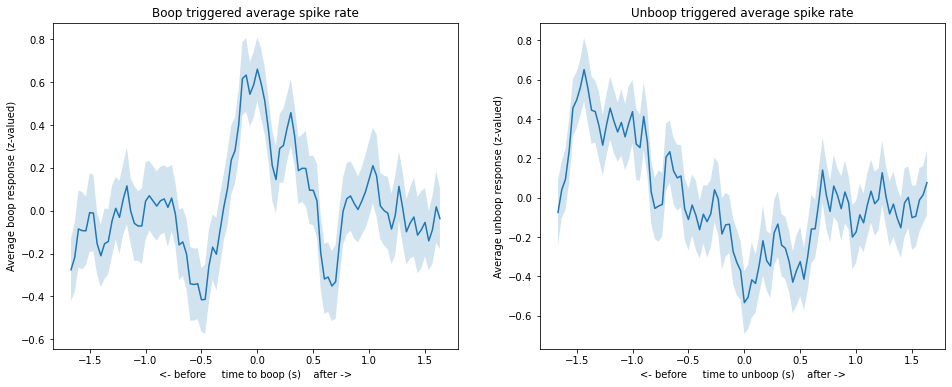

In [14]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
y = S.sum(1)

D_boop = get_time_lagged_design(df_boop.query('action == "boop"').frame.values, 
                                ts, 
                                np.median(np.diff(ts)), 
                                t_range)
pinv = np.linalg.inv(D_boop.T @ D_boop) @ D_boop.T
boopology = pinv @ ((y - y.mean()) / y.std())

bs = []
for i in range(101):
    idx = np.argsort(np.random.rand(D_boop.shape[0]))
    boopology_ = pinv @ ((y[idx] - y.mean()) / y.std())
    bs.append(boopology_)

sd = np.stack(bs).std(axis=0)

plt.plot(1/30 * t_range[::-1], boopology)
plt.fill_between(1/30 * t_range[::-1], boopology - sd, boopology + sd, alpha=.2)
plt.xlabel('<- before     time to boop (s)    after ->')
plt.ylabel('Average boop response (z-valued)')
plt.title('Boop triggered average spike rate')

plt.subplot(122)
y = S.sum(1)


D_boop = get_time_lagged_design(df_boop.query('action == "unboop"').frame.values, 
                                ts, 
                                np.median(np.diff(ts)), 
                                t_range)
pinv = np.linalg.inv(D_boop.T @ D_boop) @ D_boop.T

boopology = pinv @ ((y - y.mean()) / y.std())
bs = []
for i in range(101):
    idx = np.argsort(np.random.rand(D_boop.shape[0]))
    boopology_ = pinv @ ((y[idx] - y.mean()) / y.std())
    bs.append(boopology_)

sd = np.stack(bs).std(axis=0)

plt.plot(1/30 * t_range[::-1], boopology)
plt.fill_between(1/30 * t_range[::-1], boopology - sd, boopology + sd, alpha=.2)
plt.xlabel('<- before     time to unboop (s)    after ->')
plt.ylabel('Average unboop response (z-valued)')
plt.title('Unboop triggered average spike rate')